# Data Engineering and Visualization

In [1]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
csv_files = glob.glob('*.csv')
csv_files

['USDEUR=X.csv', 'USDCHF=X.csv', 'USDGBP=X.csv']

In [3]:
#personal preference
filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv']

In [4]:
df_train=[]
df_test=[]
df_raw=[]
for path in filepath:
    df_temp=pd.read_csv(path)
    #We no longer need date, because we can use index.
    df_temp=df_temp[['Close']]
    df_temp.columns=['rate']
    # Somehow USDCHF=X.csv has one more day 2023/11/4, which shouldn't exist.
    if (path=='USDCHF=X.csv'):
        df_temp.drop(df_temp.index[-1], inplace=True)
    df_raw.append(df_temp)
    df_train.append(df_temp[:-5])
    df_test.append(df_temp[-5:])

In [5]:
for i in range(3):
    print(len(df_raw[i]))

2610
2610
2610


In [6]:
# There is something wrong with the files downloaded from the website.
# These rows shouldn't be nan.
# In this case, we simply adopt a strategy of dropping these rows.
# 2017/7/11 2017/11/16 2019/5/22
for i in range(len(filepath)):
    rows_with_nan = df_train[0][df_train[0].isna().any(axis=1)].index
    print(rows_with_nan)
for i in range(len(filepath)):
    df_train[i]=df_train[i].dropna()

Index([961, 1053, 1447], dtype='int64')
Index([961, 1053, 1447], dtype='int64')
Index([961, 1053, 1447], dtype='int64')


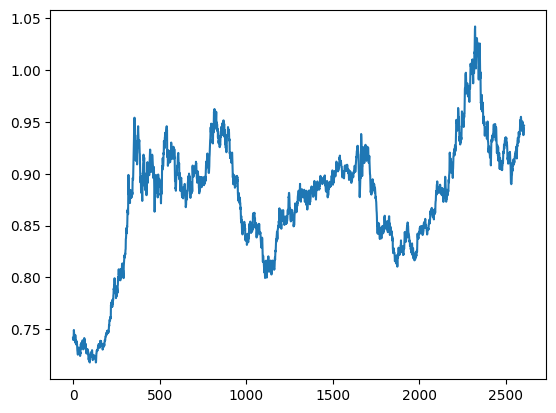

In [7]:
plt.plot(np.array(df_train[0].index),np.array(df_train[0])[:])

In [8]:
def test_stationarity(timeseries):
    # execute Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    print(f'p-value={dftest[1]}')

In [9]:
# First order difference is enough to make timeseries stationary, beacuase p-value<0.05. 
for i in range(len(filepath)):
    print(f"{i}:")
    test_stationarity(df_train[i]['rate'])
    #test first-order difference
    test_stationarity(df_train[i]['rate'].diff().dropna())

0:
p-value=0.2190404265400342
p-value=0.0
1:
p-value=0.342504520388928
p-value=0.0
2:
p-value=0.04668140961050518
p-value=0.0


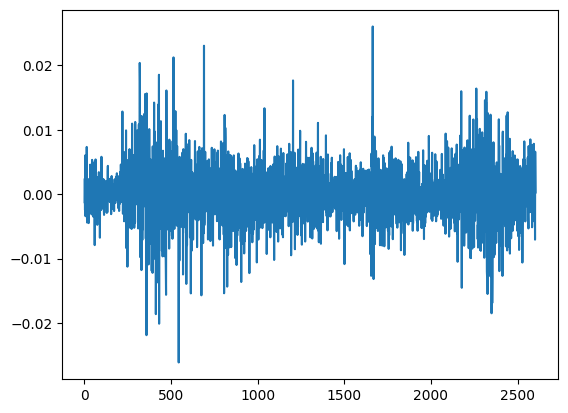

In [10]:
# By utilizing first order difference, we have made the timeseries stationary
plt.plot(df_train[0].diff().dropna())

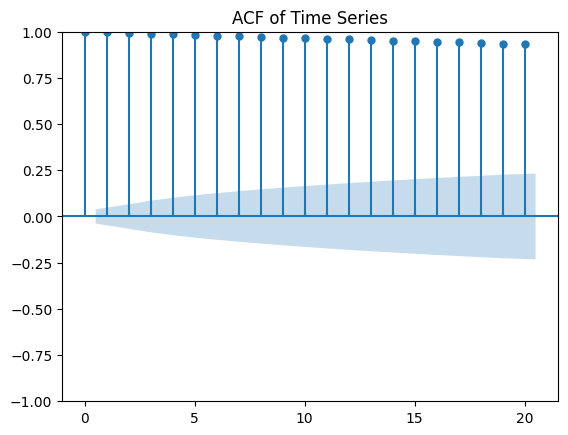

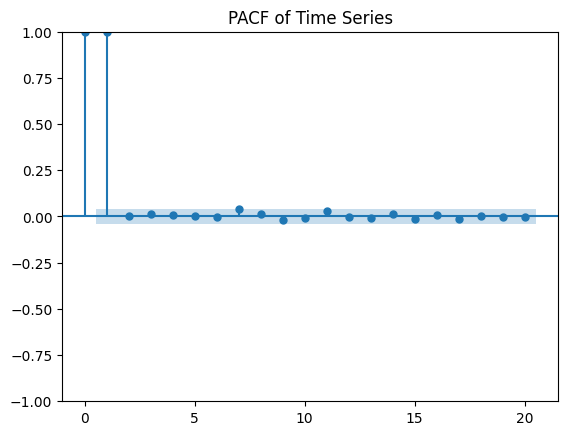

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot ACF figure
plot_acf(df_train[0], lags=20)
plt.title('ACF of Time Series')
plt.show()

# plot PACF figure
plot_pacf(df_train[0], lags=20)
plt.title('PACF of Time Series')
plt.show()

# Prophet

In [12]:
!pip3 install prophet 
!pip3 install --upgrade plotly
!pip3 install pandas_market_calendars
!pip3 install --upgrade pandas
from prophet import Prophet
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [13]:
# As prophet needs datetime and numeric value as input, I will re-process the input data here
filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv']
df_train_prophet=[]
df_test_prophet=[]
df_all_prophet = []
for path in filepath:
    df_temp=pd.read_csv(path)[["Date", "High"]] # keep both Date and High
    df_temp = df_temp.rename(columns={"Date": "ds", "High": "y"})
    df_train_prophet.append(df_temp[:-5])
    df_test_prophet.append(df_temp[-5:])
    df_all_prophet.append(df_temp)

In [14]:
df_train_prophet[0]

,ds,y
0,2013-11-04,0.743770
1,2013-11-05,0.743510
2,2013-11-06,0.742460
3,2013-11-07,0.751552
4,2013-11-08,0.750677
...,...,...
2600,2023-10-23,0.945910
2601,2023-10-24,0.944800
2602,2023-10-25,0.946360
2603,2023-10-26,0.950000


In [15]:
df_test_prophet[0]

,ds,y
2605,2023-10-30,0.94801
2606,2023-10-31,0.94629
2607,2023-11-01,0.95031
2608,2023-11-02,0.94480
2609,2023-11-03,0.94202


In [16]:
prophet_models = []

for curve_data in df_train_prophet:
    model = Prophet()
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_models.append((model, forecast))

22:13:48 - cmdstanpy - INFO - Chain [1] start processing
22:13:49 - cmdstanpy - INFO - Chain [1] done processing
22:13:49 - cmdstanpy - INFO - Chain [1] start processing
22:13:50 - cmdstanpy - INFO - Chain [1] done processing
22:13:50 - cmdstanpy - INFO - Chain [1] start processing
22:13:50 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
prophet_models[0][1]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-10-30,0.960599,0.936524,0.992651,0.960599,0.960599,0.002829,0.002829,0.002829,-0.001183,-0.001183,-0.001183,0.004012,0.004012,0.004012,0.0,0.0,0.0,0.963428
1,2023-10-31,0.960669,0.935800,0.993031,0.960669,0.960669,0.003448,0.003448,0.003448,-0.001008,-0.001008,-0.001008,0.004456,0.004456,0.004456,0.0,0.0,0.0,0.964117
2,2023-11-01,0.960739,0.938271,0.991210,0.960739,0.960739,0.003900,0.003900,0.003900,-0.001026,-0.001026,-0.001026,0.004927,0.004927,0.004927,0.0,0.0,0.0,0.964639
3,2023-11-02,0.960808,0.937892,0.991968,0.960808,0.960808,0.004726,0.004726,0.004726,-0.000691,-0.000691,-0.000691,0.005417,0.005417,0.005417,0.0,0.0,0.0,0.965534
4,2023-11-03,0.960878,0.938999,0.993053,0.960878,0.960878,0.005316,0.005316,0.005316,-0.000603,-0.000603,-0.000603,0.005919,0.005919,0.005919,0.0,0.0,0.0,0.966194


## Calculate Errors For Prediction

In [18]:
errors = []
def calculate_mse(truth, prediction):
    """ 
    truth, prediction: 5x5 array, predictions for the next 5 trading days for 5 curves 
    """
    errors = [np.mean(np.square(truth[i] - prediction)) for i in range(len(truth))]
    return errors, np.sum(errors)

calculate_mse([df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))], [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))])

([0.0034865081901248093, 0.010090937353852254, 0.002392607748287906],
 0.01597005329226497)

## Plot the ground truth and prediction

In [19]:
def draw_pred_truth(truth, pred):
    fig, axes = plt.subplots(1, len(truth), figsize=(30, 10))
    for i in range(len(filepath)):
        ax = axes[i]
        ax.plot(truth[i], label='Truth')
        ax.plot(pred[i], label='Pred')
        ax.set_title(f'Plot {i + 1}')
        ax.legend()
        ax.grid()
    plt.tight_layout()
    plt.show()

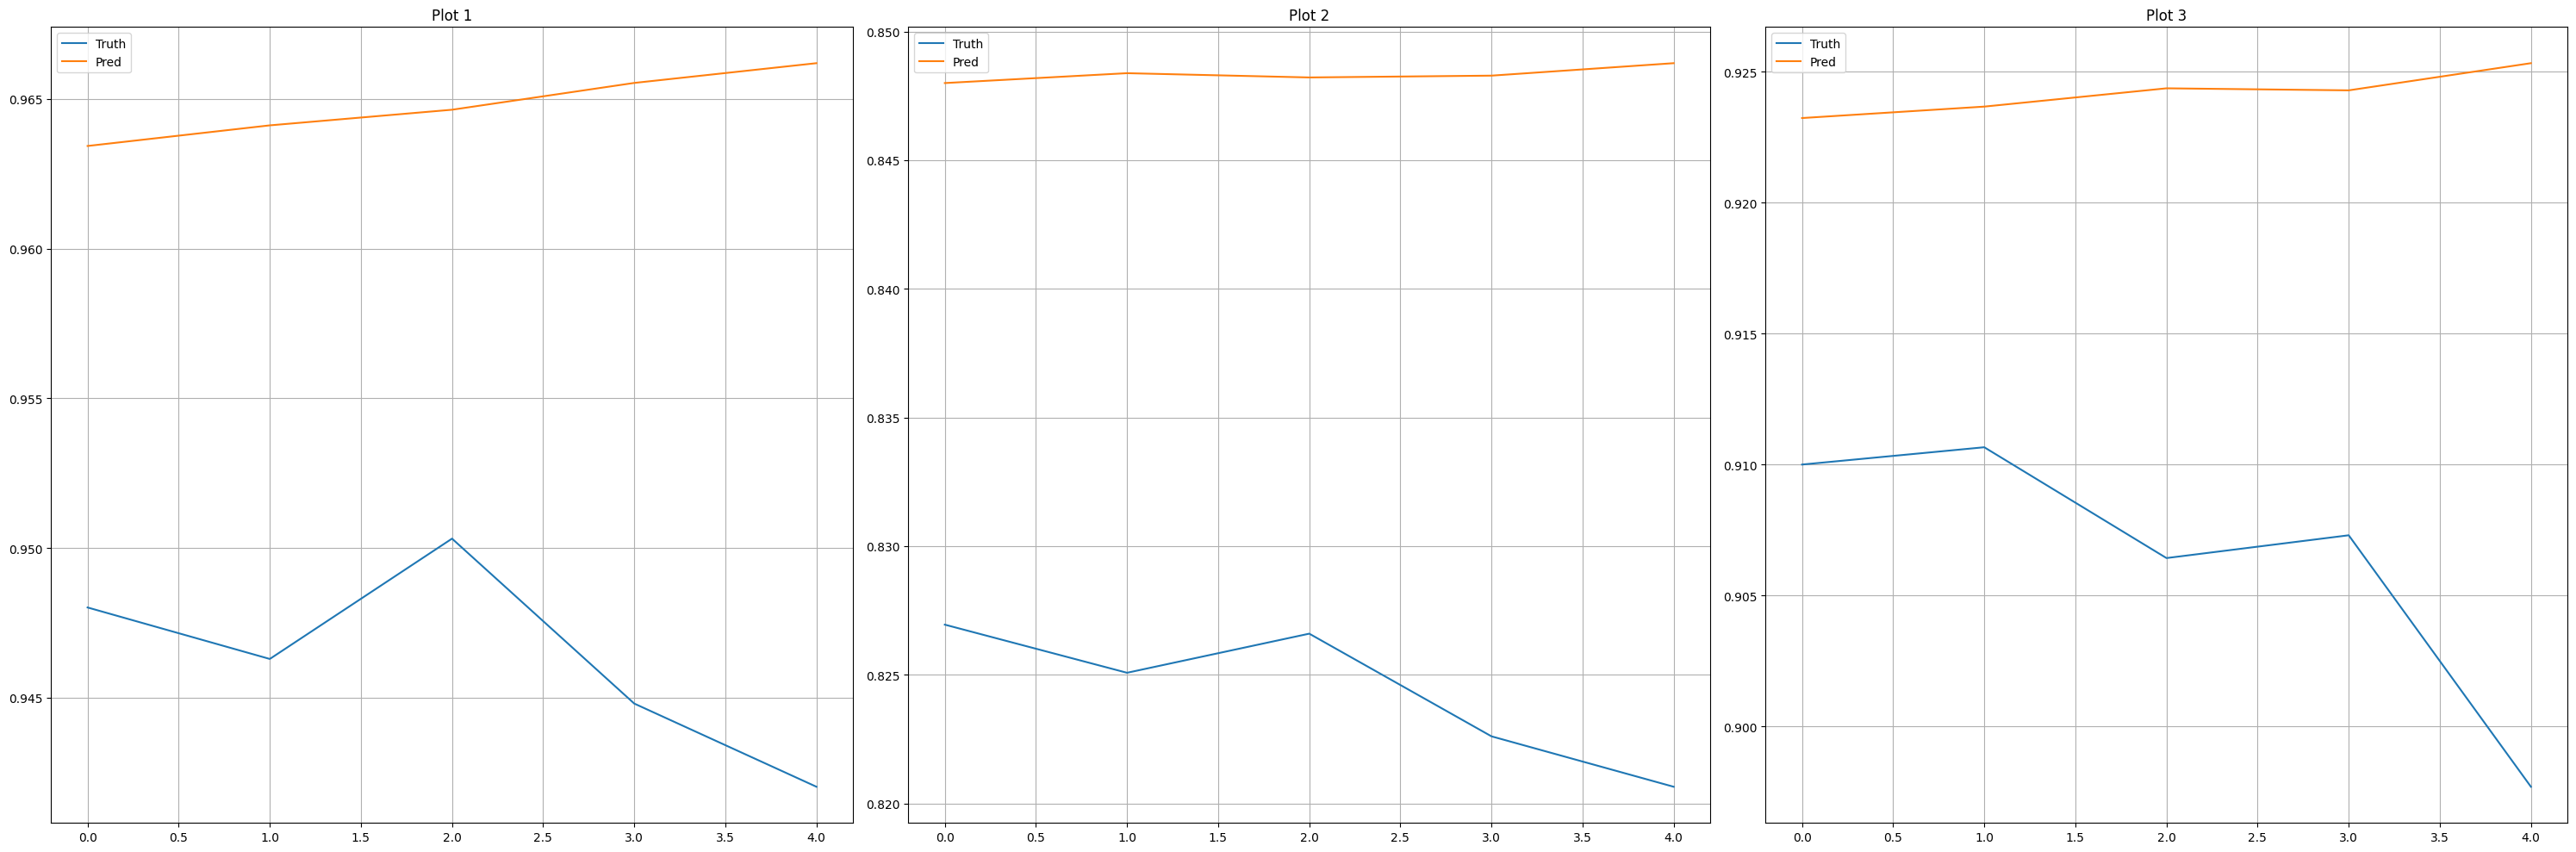

In [20]:
truth_prophet = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]
pred_prophet = [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))]
draw_pred_truth(truth_prophet, pred_prophet)

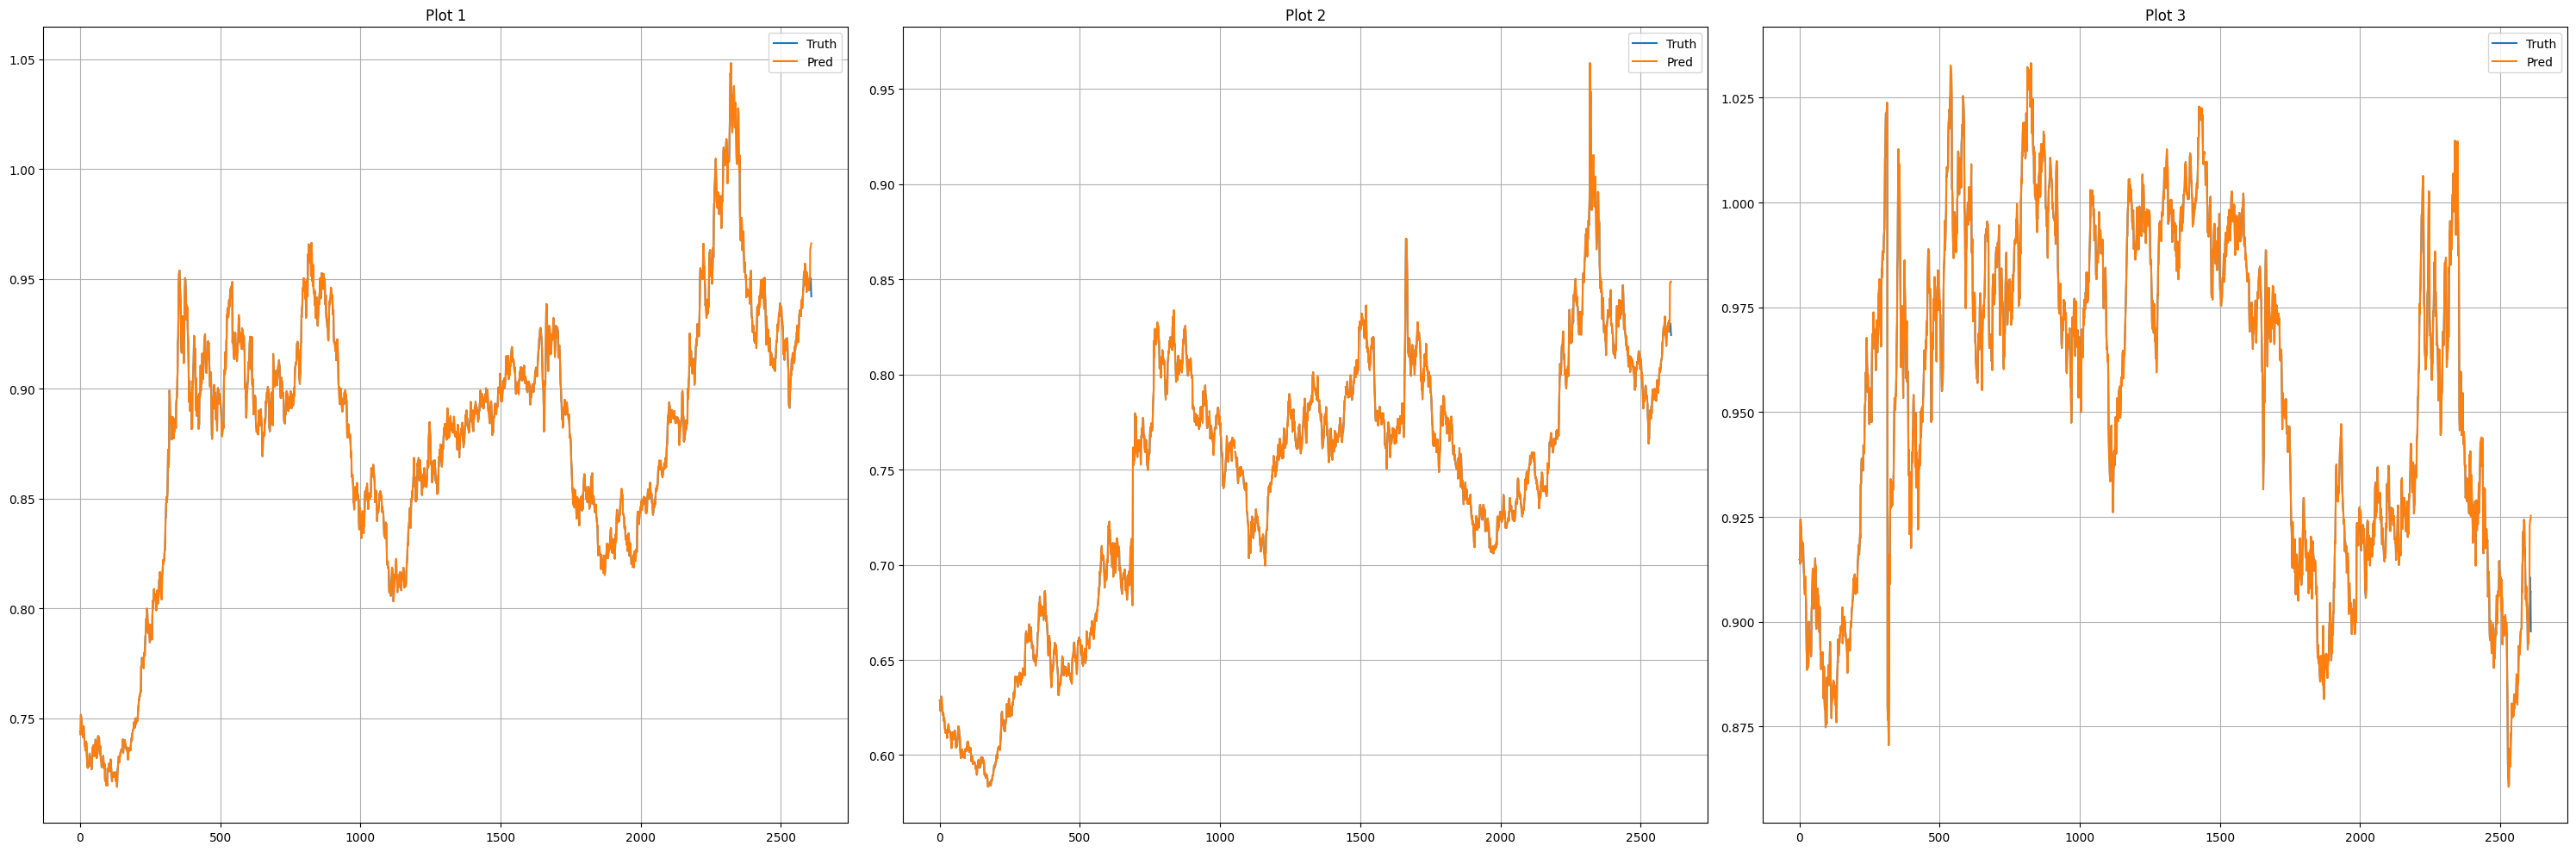

In [21]:
train_pred_prophet = [np.concatenate((df_train_prophet[i]['y'].to_numpy(), prophet_models[i][1]['yhat'].to_numpy()), axis=0) for i in range(len(df_train_prophet))]
# print(len(train_pred_prophet))
draw_pred_truth([df_all_prophet[i]['y'].to_numpy() for i in range(len(df_all_prophet))], train_pred_prophet)

## Hyper parameter tunning to find the best model

In [22]:
# Define a range of hyperparameter values to search
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1], # default 0.05
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10], # default 10
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10], # default 10
}
best_mse = float('inf')
best_params = {}
ground_truth = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]

# Iterate through the parameter grid and find the best hyperparameters
for params in ParameterGrid(param_grid):
    print(f"params is {params}")
    para_models = []
    for curve_data in df_train_prophet:
        # Create a Prophet model with the current hyperparameters
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale']
        )
        
        # Fit the model on the training data
        model.fit(curve_data)
        
        last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
        # Create a date range for the next 5 trading days, excluding weekends
        future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
        # Create a DataFrame with these dates
        future_df = pd.DataFrame({'ds': future_dates})
        # Make predictions
        forecast = model.predict(future_df)

        para_models.append((model, forecast))
    _, mse = calculate_mse(ground_truth, [para_models[i][1]['yhat'].to_numpy() for i in range(len(para_models))])
    print(f"MSE is {mse}")
    # Check if the current set of hyperparameters results in a better model
    if mse < best_mse:
        best_mse = mse
        best_params = params

print("Best Hyperparameters:")
print(best_params)
print("Best MSE:", best_mse)

22:13:51 - cmdstanpy - INFO - Chain [1] start processing


params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


22:13:52 - cmdstanpy - INFO - Chain [1] done processing
22:13:52 - cmdstanpy - INFO - Chain [1] start processing
22:13:52 - cmdstanpy - INFO - Chain [1] done processing
22:13:52 - cmdstanpy - INFO - Chain [1] start processing
22:13:52 - cmdstanpy - INFO - Chain [1] done processing
22:13:52 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018826512071919203
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


22:13:53 - cmdstanpy - INFO - Chain [1] done processing
22:13:53 - cmdstanpy - INFO - Chain [1] start processing
22:13:53 - cmdstanpy - INFO - Chain [1] done processing
22:13:53 - cmdstanpy - INFO - Chain [1] start processing
22:13:54 - cmdstanpy - INFO - Chain [1] done processing
22:13:54 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018796881487143258
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


22:13:54 - cmdstanpy - INFO - Chain [1] done processing
22:13:54 - cmdstanpy - INFO - Chain [1] start processing
22:13:54 - cmdstanpy - INFO - Chain [1] done processing
22:13:54 - cmdstanpy - INFO - Chain [1] start processing
22:13:55 - cmdstanpy - INFO - Chain [1] done processing
22:13:55 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01881974051981611
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


22:13:55 - cmdstanpy - INFO - Chain [1] done processing
22:13:55 - cmdstanpy - INFO - Chain [1] start processing
22:13:55 - cmdstanpy - INFO - Chain [1] done processing
22:13:55 - cmdstanpy - INFO - Chain [1] start processing
22:13:56 - cmdstanpy - INFO - Chain [1] done processing
22:13:56 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018592488828151323
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


22:13:56 - cmdstanpy - INFO - Chain [1] done processing
22:13:56 - cmdstanpy - INFO - Chain [1] start processing
22:13:56 - cmdstanpy - INFO - Chain [1] done processing
22:13:57 - cmdstanpy - INFO - Chain [1] start processing
22:13:57 - cmdstanpy - INFO - Chain [1] done processing
22:13:57 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018826512071919203
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


22:13:57 - cmdstanpy - INFO - Chain [1] done processing
22:13:57 - cmdstanpy - INFO - Chain [1] start processing
22:13:58 - cmdstanpy - INFO - Chain [1] done processing
22:13:58 - cmdstanpy - INFO - Chain [1] start processing
22:13:58 - cmdstanpy - INFO - Chain [1] done processing
22:13:58 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018796881487143258
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


22:13:58 - cmdstanpy - INFO - Chain [1] done processing
22:13:58 - cmdstanpy - INFO - Chain [1] start processing
22:13:59 - cmdstanpy - INFO - Chain [1] done processing
22:13:59 - cmdstanpy - INFO - Chain [1] start processing
22:13:59 - cmdstanpy - INFO - Chain [1] done processing
22:13:59 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01881974051981611
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


22:13:59 - cmdstanpy - INFO - Chain [1] done processing
22:13:59 - cmdstanpy - INFO - Chain [1] start processing
22:14:00 - cmdstanpy - INFO - Chain [1] done processing
22:14:00 - cmdstanpy - INFO - Chain [1] start processing
22:14:00 - cmdstanpy - INFO - Chain [1] done processing
22:14:00 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018592488828151323
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


22:14:00 - cmdstanpy - INFO - Chain [1] done processing
22:14:01 - cmdstanpy - INFO - Chain [1] start processing
22:14:01 - cmdstanpy - INFO - Chain [1] done processing
22:14:01 - cmdstanpy - INFO - Chain [1] start processing
22:14:01 - cmdstanpy - INFO - Chain [1] done processing
22:14:01 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018826512071919203
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


22:14:02 - cmdstanpy - INFO - Chain [1] done processing
22:14:02 - cmdstanpy - INFO - Chain [1] start processing
22:14:02 - cmdstanpy - INFO - Chain [1] done processing
22:14:02 - cmdstanpy - INFO - Chain [1] start processing
22:14:02 - cmdstanpy - INFO - Chain [1] done processing
22:14:02 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018796881487143258
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


22:14:03 - cmdstanpy - INFO - Chain [1] done processing
22:14:03 - cmdstanpy - INFO - Chain [1] start processing
22:14:03 - cmdstanpy - INFO - Chain [1] done processing
22:14:03 - cmdstanpy - INFO - Chain [1] start processing
22:14:03 - cmdstanpy - INFO - Chain [1] done processing
22:14:03 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01881974051981611
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


22:14:04 - cmdstanpy - INFO - Chain [1] done processing
22:14:04 - cmdstanpy - INFO - Chain [1] start processing
22:14:04 - cmdstanpy - INFO - Chain [1] done processing
22:14:04 - cmdstanpy - INFO - Chain [1] start processing
22:14:04 - cmdstanpy - INFO - Chain [1] done processing
22:14:05 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018592488828151323
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


22:14:05 - cmdstanpy - INFO - Chain [1] done processing
22:14:05 - cmdstanpy - INFO - Chain [1] start processing
22:14:05 - cmdstanpy - INFO - Chain [1] done processing
22:14:05 - cmdstanpy - INFO - Chain [1] start processing
22:14:06 - cmdstanpy - INFO - Chain [1] done processing
22:14:06 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018826512071919203
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


22:14:06 - cmdstanpy - INFO - Chain [1] done processing
22:14:06 - cmdstanpy - INFO - Chain [1] start processing
22:14:06 - cmdstanpy - INFO - Chain [1] done processing
22:14:07 - cmdstanpy - INFO - Chain [1] start processing
22:14:07 - cmdstanpy - INFO - Chain [1] done processing
22:14:07 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018796881487143258
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


22:14:07 - cmdstanpy - INFO - Chain [1] done processing
22:14:07 - cmdstanpy - INFO - Chain [1] start processing
22:14:08 - cmdstanpy - INFO - Chain [1] done processing
22:14:08 - cmdstanpy - INFO - Chain [1] start processing
22:14:08 - cmdstanpy - INFO - Chain [1] done processing
22:14:08 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01881974051981611
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


22:14:08 - cmdstanpy - INFO - Chain [1] done processing
22:14:08 - cmdstanpy - INFO - Chain [1] start processing
22:14:08 - cmdstanpy - INFO - Chain [1] done processing
22:14:09 - cmdstanpy - INFO - Chain [1] start processing
22:14:09 - cmdstanpy - INFO - Chain [1] done processing
22:14:09 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018592488828151323
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


22:14:10 - cmdstanpy - INFO - Chain [1] done processing
22:14:10 - cmdstanpy - INFO - Chain [1] start processing
22:14:10 - cmdstanpy - INFO - Chain [1] done processing
22:14:10 - cmdstanpy - INFO - Chain [1] start processing
22:14:11 - cmdstanpy - INFO - Chain [1] done processing
22:14:11 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01589374619980191
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


22:14:12 - cmdstanpy - INFO - Chain [1] done processing
22:14:12 - cmdstanpy - INFO - Chain [1] start processing
22:14:12 - cmdstanpy - INFO - Chain [1] done processing
22:14:12 - cmdstanpy - INFO - Chain [1] start processing
22:14:13 - cmdstanpy - INFO - Chain [1] done processing
22:14:13 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015839599902913778
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


22:14:14 - cmdstanpy - INFO - Chain [1] done processing
22:14:14 - cmdstanpy - INFO - Chain [1] start processing
22:14:14 - cmdstanpy - INFO - Chain [1] done processing
22:14:15 - cmdstanpy - INFO - Chain [1] start processing
22:14:15 - cmdstanpy - INFO - Chain [1] done processing
22:14:15 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015960884585009272
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


22:14:16 - cmdstanpy - INFO - Chain [1] done processing
22:14:16 - cmdstanpy - INFO - Chain [1] start processing
22:14:16 - cmdstanpy - INFO - Chain [1] done processing
22:14:16 - cmdstanpy - INFO - Chain [1] start processing
22:14:17 - cmdstanpy - INFO - Chain [1] done processing
22:14:17 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01597005329226497
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


22:14:18 - cmdstanpy - INFO - Chain [1] done processing
22:14:18 - cmdstanpy - INFO - Chain [1] start processing
22:14:18 - cmdstanpy - INFO - Chain [1] done processing
22:14:18 - cmdstanpy - INFO - Chain [1] start processing
22:14:19 - cmdstanpy - INFO - Chain [1] done processing
22:14:19 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01589374619980191
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


22:14:20 - cmdstanpy - INFO - Chain [1] done processing
22:14:20 - cmdstanpy - INFO - Chain [1] start processing
22:14:20 - cmdstanpy - INFO - Chain [1] done processing
22:14:21 - cmdstanpy - INFO - Chain [1] start processing
22:14:21 - cmdstanpy - INFO - Chain [1] done processing
22:14:21 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015839599902913778
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


22:14:22 - cmdstanpy - INFO - Chain [1] done processing
22:14:22 - cmdstanpy - INFO - Chain [1] start processing
22:14:23 - cmdstanpy - INFO - Chain [1] done processing
22:14:23 - cmdstanpy - INFO - Chain [1] start processing
22:14:23 - cmdstanpy - INFO - Chain [1] done processing
22:14:23 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015960884585009272
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


22:14:24 - cmdstanpy - INFO - Chain [1] done processing
22:14:24 - cmdstanpy - INFO - Chain [1] start processing
22:14:24 - cmdstanpy - INFO - Chain [1] done processing
22:14:24 - cmdstanpy - INFO - Chain [1] start processing
22:14:25 - cmdstanpy - INFO - Chain [1] done processing
22:14:25 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01597005329226497
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


22:14:26 - cmdstanpy - INFO - Chain [1] done processing
22:14:26 - cmdstanpy - INFO - Chain [1] start processing
22:14:26 - cmdstanpy - INFO - Chain [1] done processing
22:14:26 - cmdstanpy - INFO - Chain [1] start processing
22:14:27 - cmdstanpy - INFO - Chain [1] done processing
22:14:27 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01589374619980191
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


22:14:28 - cmdstanpy - INFO - Chain [1] done processing
22:14:28 - cmdstanpy - INFO - Chain [1] start processing
22:14:29 - cmdstanpy - INFO - Chain [1] done processing
22:14:29 - cmdstanpy - INFO - Chain [1] start processing
22:14:29 - cmdstanpy - INFO - Chain [1] done processing
22:14:29 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015839599902913778
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


22:14:30 - cmdstanpy - INFO - Chain [1] done processing
22:14:30 - cmdstanpy - INFO - Chain [1] start processing
22:14:31 - cmdstanpy - INFO - Chain [1] done processing
22:14:31 - cmdstanpy - INFO - Chain [1] start processing
22:14:31 - cmdstanpy - INFO - Chain [1] done processing
22:14:31 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015960884585009272
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


22:14:32 - cmdstanpy - INFO - Chain [1] done processing
22:14:32 - cmdstanpy - INFO - Chain [1] start processing
22:14:32 - cmdstanpy - INFO - Chain [1] done processing
22:14:33 - cmdstanpy - INFO - Chain [1] start processing
22:14:33 - cmdstanpy - INFO - Chain [1] done processing
22:14:33 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01597005329226497
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


22:14:34 - cmdstanpy - INFO - Chain [1] done processing
22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing
22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:35 - cmdstanpy - INFO - Chain [1] done processing
22:14:35 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01589374619980191
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


22:14:36 - cmdstanpy - INFO - Chain [1] done processing
22:14:36 - cmdstanpy - INFO - Chain [1] start processing
22:14:37 - cmdstanpy - INFO - Chain [1] done processing
22:14:37 - cmdstanpy - INFO - Chain [1] start processing
22:14:37 - cmdstanpy - INFO - Chain [1] done processing
22:14:38 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015839599902913778
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


22:14:38 - cmdstanpy - INFO - Chain [1] done processing
22:14:38 - cmdstanpy - INFO - Chain [1] start processing
22:14:39 - cmdstanpy - INFO - Chain [1] done processing
22:14:39 - cmdstanpy - INFO - Chain [1] start processing
22:14:39 - cmdstanpy - INFO - Chain [1] done processing
22:14:39 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015960884585009272
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


22:14:40 - cmdstanpy - INFO - Chain [1] done processing
22:14:40 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01597005329226497
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


22:14:42 - cmdstanpy - INFO - Chain [1] done processing
22:14:42 - cmdstanpy - INFO - Chain [1] start processing
22:14:43 - cmdstanpy - INFO - Chain [1] done processing
22:14:43 - cmdstanpy - INFO - Chain [1] start processing
22:14:44 - cmdstanpy - INFO - Chain [1] done processing
22:14:44 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01525076903032153
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


22:14:45 - cmdstanpy - INFO - Chain [1] done processing
22:14:45 - cmdstanpy - INFO - Chain [1] start processing
22:14:46 - cmdstanpy - INFO - Chain [1] done processing
22:14:46 - cmdstanpy - INFO - Chain [1] start processing
22:14:46 - cmdstanpy - INFO - Chain [1] done processing
22:14:47 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015284142788935506
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


22:14:47 - cmdstanpy - INFO - Chain [1] done processing
22:14:48 - cmdstanpy - INFO - Chain [1] start processing
22:14:48 - cmdstanpy - INFO - Chain [1] done processing
22:14:48 - cmdstanpy - INFO - Chain [1] start processing
22:14:49 - cmdstanpy - INFO - Chain [1] done processing
22:14:49 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015296589049467662
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


22:14:50 - cmdstanpy - INFO - Chain [1] done processing
22:14:50 - cmdstanpy - INFO - Chain [1] start processing
22:14:51 - cmdstanpy - INFO - Chain [1] done processing
22:14:51 - cmdstanpy - INFO - Chain [1] start processing
22:14:51 - cmdstanpy - INFO - Chain [1] done processing
22:14:52 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015300558136363867
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


22:14:52 - cmdstanpy - INFO - Chain [1] done processing
22:14:52 - cmdstanpy - INFO - Chain [1] start processing
22:14:53 - cmdstanpy - INFO - Chain [1] done processing
22:14:53 - cmdstanpy - INFO - Chain [1] start processing
22:14:54 - cmdstanpy - INFO - Chain [1] done processing
22:14:54 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01525076903032153
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


22:14:55 - cmdstanpy - INFO - Chain [1] done processing
22:14:55 - cmdstanpy - INFO - Chain [1] start processing
22:14:56 - cmdstanpy - INFO - Chain [1] done processing
22:14:56 - cmdstanpy - INFO - Chain [1] start processing
22:14:57 - cmdstanpy - INFO - Chain [1] done processing
22:14:57 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015284142788935506
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


22:14:58 - cmdstanpy - INFO - Chain [1] done processing
22:14:58 - cmdstanpy - INFO - Chain [1] start processing
22:14:58 - cmdstanpy - INFO - Chain [1] done processing
22:14:59 - cmdstanpy - INFO - Chain [1] start processing
22:14:59 - cmdstanpy - INFO - Chain [1] done processing
22:14:59 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015296589049467662
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


22:15:00 - cmdstanpy - INFO - Chain [1] done processing
22:15:00 - cmdstanpy - INFO - Chain [1] start processing
22:15:01 - cmdstanpy - INFO - Chain [1] done processing
22:15:01 - cmdstanpy - INFO - Chain [1] start processing
22:15:02 - cmdstanpy - INFO - Chain [1] done processing
22:15:02 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015300558136363867
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


22:15:02 - cmdstanpy - INFO - Chain [1] done processing
22:15:02 - cmdstanpy - INFO - Chain [1] start processing
22:15:03 - cmdstanpy - INFO - Chain [1] done processing
22:15:03 - cmdstanpy - INFO - Chain [1] start processing
22:15:04 - cmdstanpy - INFO - Chain [1] done processing
22:15:04 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01525076903032153
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


22:15:05 - cmdstanpy - INFO - Chain [1] done processing
22:15:05 - cmdstanpy - INFO - Chain [1] start processing
22:15:06 - cmdstanpy - INFO - Chain [1] done processing
22:15:06 - cmdstanpy - INFO - Chain [1] start processing
22:15:07 - cmdstanpy - INFO - Chain [1] done processing
22:15:07 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015284142788935506
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


22:15:08 - cmdstanpy - INFO - Chain [1] done processing
22:15:08 - cmdstanpy - INFO - Chain [1] start processing
22:15:09 - cmdstanpy - INFO - Chain [1] done processing
22:15:09 - cmdstanpy - INFO - Chain [1] start processing
22:15:09 - cmdstanpy - INFO - Chain [1] done processing
22:15:10 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015296589049467662
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


22:15:10 - cmdstanpy - INFO - Chain [1] done processing
22:15:10 - cmdstanpy - INFO - Chain [1] start processing
22:15:11 - cmdstanpy - INFO - Chain [1] done processing
22:15:11 - cmdstanpy - INFO - Chain [1] start processing
22:15:12 - cmdstanpy - INFO - Chain [1] done processing
22:15:12 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015300558136363867
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


22:15:13 - cmdstanpy - INFO - Chain [1] done processing
22:15:13 - cmdstanpy - INFO - Chain [1] start processing
22:15:13 - cmdstanpy - INFO - Chain [1] done processing
22:15:14 - cmdstanpy - INFO - Chain [1] start processing
22:15:14 - cmdstanpy - INFO - Chain [1] done processing
22:15:14 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01525076903032153
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


22:15:15 - cmdstanpy - INFO - Chain [1] done processing
22:15:15 - cmdstanpy - INFO - Chain [1] start processing
22:15:16 - cmdstanpy - INFO - Chain [1] done processing
22:15:16 - cmdstanpy - INFO - Chain [1] start processing
22:15:17 - cmdstanpy - INFO - Chain [1] done processing
22:15:17 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015284142788935506
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


22:15:18 - cmdstanpy - INFO - Chain [1] done processing
22:15:18 - cmdstanpy - INFO - Chain [1] start processing
22:15:19 - cmdstanpy - INFO - Chain [1] done processing
22:15:19 - cmdstanpy - INFO - Chain [1] start processing
22:15:20 - cmdstanpy - INFO - Chain [1] done processing
22:15:20 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015296589049467662
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


22:15:20 - cmdstanpy - INFO - Chain [1] done processing
22:15:20 - cmdstanpy - INFO - Chain [1] start processing
22:15:21 - cmdstanpy - INFO - Chain [1] done processing
22:15:21 - cmdstanpy - INFO - Chain [1] start processing
22:15:22 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015300558136363867
Best Hyperparameters:
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
Best MSE: 0.01525076903032153


In [23]:
# Best Hyperparameters:
# {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
# Best MSE: 0.07732153857925472

## Now predict using the best model 

22:15:22 - cmdstanpy - INFO - Chain [1] start processing
22:15:23 - cmdstanpy - INFO - Chain [1] done processing
22:15:23 - cmdstanpy - INFO - Chain [1] start processing
22:15:24 - cmdstanpy - INFO - Chain [1] done processing
22:15:24 - cmdstanpy - INFO - Chain [1] start processing
22:15:25 - cmdstanpy - INFO - Chain [1] done processing


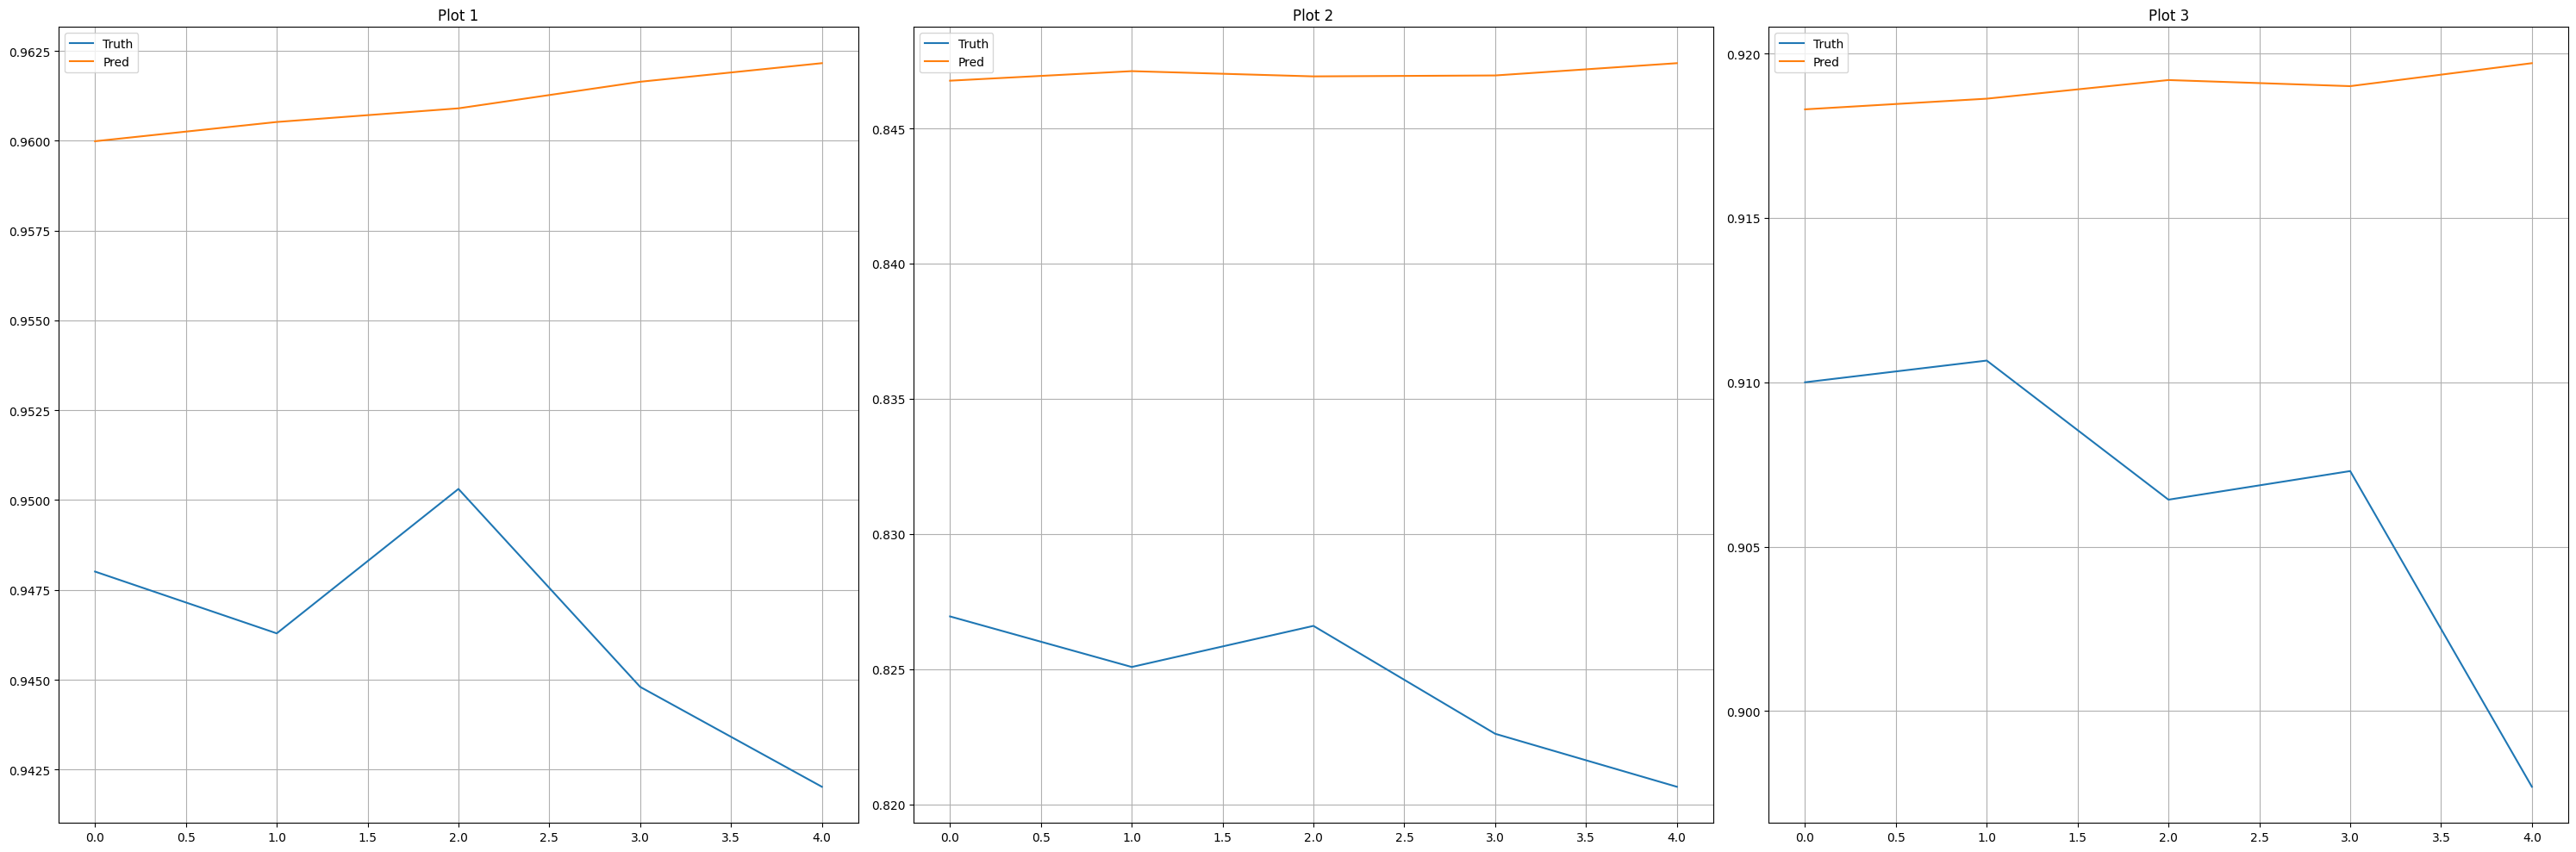

In [24]:
prophet_models = []

for curve_data in df_train_prophet:
    model = Prophet(
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=0.01,
        holidays_prior_scale=0.1
    )
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_models.append((model, forecast))

truth_prophet = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]
pred_prophet = [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))]
draw_pred_truth(truth_prophet, pred_prophet)

# ARIMA

In [25]:
#split train_dataset into train_dataset and validation_dataset, we set validation_dataset size to be 5, which conforms to test_dataset size
train_size=len(df_train[0][:-5])

train=np.array(df_train[0]['rate'])[:train_size]
val=np.array(df_train[0]['rate'])[train_size:]

In [26]:
print(train.shape,val.shape)

(2597,) (5,)


In [27]:
# train ARIMA model
from statsmodels.tsa.arima.model import ARIMA

#Since we have already applied difference on data, we set d=0 here.
p,d,q=1,2,1
model = ARIMA(train, order=(p, d, q))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2597
Model:                 ARIMA(1, 2, 1)   Log Likelihood               10179.533
Date:                Sat, 04 Nov 2023   AIC                         -20353.066
Time:                        22:15:25   BIC                         -20335.482
Sample:                             0   HQIC                        -20346.695
                               - 2597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0033      0.020      0.169      0.866      -0.035       0.042
ma.L1         -0.7564      0.016    -46.935      0.000      -0.788      -0.725
sigma2      2.288e-05   4.43e-07     51.680      0.0

In [28]:
train

array([0.74107, 0.73981, 0.74222, ..., 0.9458 , 0.9489 , 0.9446 ])

In [29]:
# prediction
train_predictions = result.predict(start=1, end=train.shape[0])
print(train_predictions)

val_predictions = result.get_forecast(len(val)).predicted_mean
print(val_predictions)

[1.111605   0.73855    0.7428708  ... 0.94543074 0.94939189 0.94389979]
[0.94389979 0.94321149 0.94252323 0.94183498 0.94114672]


In [30]:
val

array([0.94429, 0.93722, 0.94381, 0.94632, 0.94657])

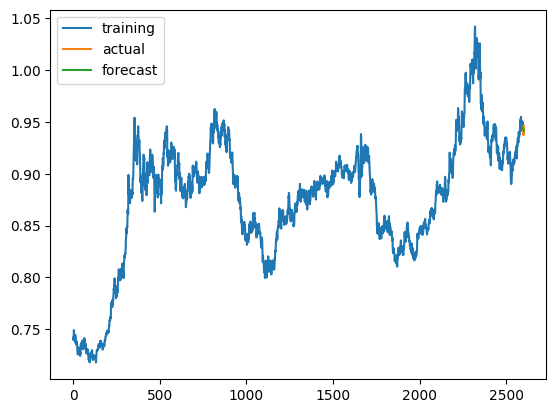

In [31]:
plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

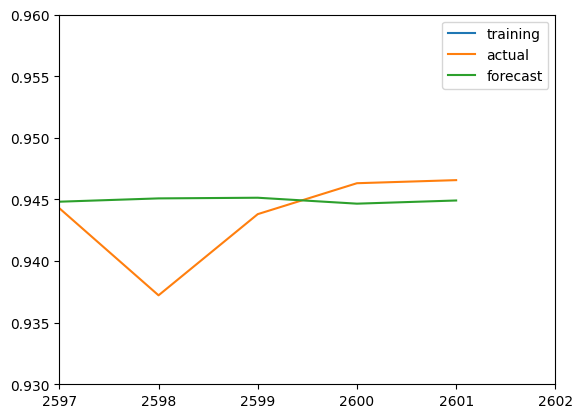

In [61]:
plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.xlim(len(train), len(train)+len(val))
plt.ylim(0.93, 0.96)
plt.legend()

In [33]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(train_predictions,train)
val_mse = mean_squared_error(val_predictions, val)

print("train_MSE:", train_mse)
print("val_MSE:", val_mse)

train_MSE: 5.5470984806165804e-05
val_MSE: 1.744668848540088e-05


## Fine-tuning

In [34]:
#gird search
min_val_mse=1e9
optimal_p=1
optimal_d=1
optimal_q=1
for p in range(1,6):
    for d in range(1,3):
        for q in range(1,6):
            model = ARIMA(train, order=(p, d, q))
            result = model.fit()
            train_predictions = result.predict(start=1, end=train.shape[0])
            val_predictions = result.get_forecast(len(val)).predicted_mean
            train_mse = mean_squared_error(train_predictions,train)
            val_mse = mean_squared_error(val_predictions, val)
            if (val_mse<min_val_mse):
                min_val_mse=val_mse
                optimal_p=p
                optimal_q=q
                optimal_d=d
            print(f"p={p},d={d},q={q}:")
            print("train_MSE:", train_mse)
            print("val_MSE:", val_mse)
            print("-------------------------------------------------------------")

p=1,d=1,q=1:
train_MSE: 5.6222814148842284e-08
val_MSE: 1.2565155350526682e-05
-------------------------------------------------------------
p=1,d=1,q=2:
train_MSE: 4.804952925488441e-09
val_MSE: 1.2490400324972694e-05
-------------------------------------------------------------
p=1,d=1,q=3:
train_MSE: 6.490424949203998e-09
val_MSE: 1.2451416385811145e-05
-------------------------------------------------------------
p=1,d=1,q=4:
train_MSE: 6.974655658789518e-09
val_MSE: 1.2455803487680617e-05
-------------------------------------------------------------
p=1,d=1,q=5:
train_MSE: 9.812872026217593e-09
val_MSE: 1.23860028074822e-05
-------------------------------------------------------------
p=1,d=2,q=1:
train_MSE: 5.5470984806165804e-05
val_MSE: 1.744668848540088e-05
-------------------------------------------------------------
p=1,d=2,q=2:
train_MSE: 5.444922593016741e-05
val_MSE: 1.381108325725283e-05
-------------------------------------------------------------
p=1,d=2,q=3:
train_MSE

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=2,d=1,q=2:
train_MSE: 1.0308505929660309e-08
val_MSE: 1.283124320335454e-05
-------------------------------------------------------------
p=2,d=1,q=3:
train_MSE: 6.33452171150614e-09
val_MSE: 1.2401980550901475e-05
-------------------------------------------------------------
p=2,d=1,q=4:
train_MSE: 7.69082141590808e-09
val_MSE: 1.2471527910867198e-05
-------------------------------------------------------------
p=2,d=1,q=5:
train_MSE: 1.0382692316241156e-08
val_MSE: 1.2328061681645358e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=2,d=2,q=1:
train_MSE: 5.291992107128736e-05
val_MSE: 1.2642306373188155e-05
-------------------------------------------------------------
p=2,d=2,q=2:
train_MSE: 5.451466717425703e-05
val_MSE: 1.4160193077047734e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=2,d=2,q=3:
train_MSE: 5.290669310736227e-05
val_MSE: 1.2448938726910449e-05
-------------------------------------------------------------
p=2,d=2,q=4:
train_MSE: 5.3663740764778745e-05
val_MSE: 1.2483918147014464e-05
-------------------------------------------------------------
p=2,d=2,q=5:
train_MSE: 5.35452132646711e-05
val_MSE: 1.252050444357281e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=3,d=1,q=1:
train_MSE: 1.0645112143001522e-18
val_MSE: 1.2404781065742911e-05
-------------------------------------------------------------
p=3,d=1,q=2:
train_MSE: 6.03252046804869e-08
val_MSE: 1.2441885704974039e-05
-------------------------------------------------------------
p=3,d=1,q=3:
train_MSE: 6.3243225734459004e-09
val_MSE: 1.2401515414159835e-05
-------------------------------------------------------------
p=3,d=1,q=4:
train_MSE: 7.288370529669175e-09
val_MSE: 1.2348049864931436e-05
-------------------------------------------------------------
p=3,d=1,q=5:
train_MSE: 1.0922985416718382e-08
val_MSE: 1.2238072530667396e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=2,q=1:
train_MSE: 5.3028244038681686e-05
val_MSE: 1.3251617563946991e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=2,q=2:
train_MSE: 5.294837243846555e-05
val_MSE: 1.2718625934971314e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=2,q=3:
train_MSE: 5.2908766747580835e-05
val_MSE: 1.2558215272556419e-05
-------------------------------------------------------------
p=3,d=2,q=4:
train_MSE: 5.367192369127105e-05
val_MSE: 1.2605127781010654e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=3,d=2,q=5:
train_MSE: 5.357017872119797e-05
val_MSE: 1.2202557312738311e-05
-------------------------------------------------------------
p=4,d=1,q=1:
train_MSE: 1.0075217286548163e-19
val_MSE: 1.240478025113697e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=4,d=1,q=2:
train_MSE: 6.256038593181408e-18
val_MSE: 1.240478250341097e-05
-------------------------------------------------------------
p=4,d=1,q=3:
train_MSE: 6.2624337002756375e-09
val_MSE: 1.2425736624772603e-05
-------------------------------------------------------------
p=4,d=1,q=4:
train_MSE: 8.904956742204097e-08
val_MSE: 1.1170487287606341e-05
-------------------------------------------------------------
p=4,d=1,q=5:
train_MSE: 1.2671070918737465e-08
val_MSE: 1.2047952988138419e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=1:
train_MSE: 5.403243307421771e-05
val_MSE: 1.7466761133631045e-05
-------------------------------------------------------------
p=4,d=2,q=2:
train_MSE: 5.38741602689767e-05
val_MSE: 1.3843685944292218e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=3:
train_MSE: 5.300699974013246e-05
val_MSE: 1.2685083893318588e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=4:
train_MSE: 5.3057871674710714e-05
val_MSE: 1.2808780056111278e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=4,d=2,q=5:
train_MSE: 5.302963494998327e-05
val_MSE: 1.1272956816471871e-05
-------------------------------------------------------------
p=5,d=1,q=1:
train_MSE: 2.824243388152051e-19
val_MSE: 1.2404780268176136e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=5,d=1,q=2:
train_MSE: 7.437486660823247e-18
val_MSE: 1.2404782052334855e-05
-------------------------------------------------------------
p=5,d=1,q=3:
train_MSE: 9.642275353933957e-09
val_MSE: 1.2361971403047789e-05
-------------------------------------------------------------
p=5,d=1,q=4:
train_MSE: 2.5442501532042065e-08
val_MSE: 1.1670178577961053e-05
-------------------------------------------------------------
p=5,d=1,q=5:
train_MSE: 1.3717267997441817e-08
val_MSE: 1.1962171519828576e-05
-------------------------------------------------------------
p=5,d=2,q=1:
train_MSE: 5.564086978072232e-05
val_MSE: 1.5999975117418717e-05
-------------------------------------------------------------
p=5,d=2,q=2:
train_MSE: 5.432707086015491e-05
val_MSE: 1.270446069202157e-05
-------------------------------------------------------------
p=5,d=2,q=3:
train_MSE: 5.3879406554549924e-05
val_MSE: 1.1682926850542322e-05
-------------------------------------------------------------
p=5,d=2,q=4:
train

In [35]:
print(optimal_p,optimal_d,optimal_q)

5 2 5


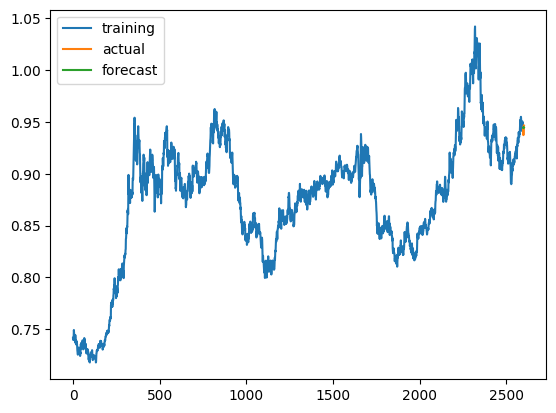

In [36]:
#visualize the best case
model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
result = model.fit()

train_predictions = result.predict(start=1, end=train.shape[0])
val_predictions = result.get_forecast(len(val)).predicted_mean

plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

## Modularization

In [37]:
def fine_tune(df):
    #split dataset
    train_size=len(df[:-5])

    train=np.array(df['rate'])[:train_size]
    val=np.array(df['rate'])[train_size:]
    
    #fine-tuning
    min_val_mse=1e9
    optimal_p=1
    optimal_d=1
    optimal_q=1
    for p in range(1,6):
        for d in range(1,3):
            for q in range(1,6):
                model = ARIMA(train, order=(p, d, q))
                result = model.fit()
                train_predictions = result.predict(start=1, end=train.shape[0])
                val_predictions = result.get_forecast(len(val)).predicted_mean
                train_mse = mean_squared_error(train_predictions,train)
                val_mse = mean_squared_error(val_predictions, val)
                if (val_mse<min_val_mse):
                    min_val_mse=val_mse
                    optimal_p=p
                    optimal_q=q
                    optimal_d=d
    
    return optimal_p,optimal_d,optimal_q

In [38]:
#find best hyper parameters for each dataset
best_parameters=[]
for i in range(len(filepath)):
    best_parameters.append(fine_tune(df_train[i]))

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/states

C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarni

In [39]:
print(best_parameters)

[(5, 2, 5), (2, 1, 5), (5, 1, 5)]


In [40]:
def get_best_model(df,best_parameter):
    #train using the whole training dataset
    train=np.array(df['rate'])

    
    #visualize the best case
    optimal_p, optimal_d, optimal_q=best_parameter
    model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
    result = model.fit()

    train_predictions = result.predict(start=1, end=train.shape[0])

    plt.plot(train,label='training')
    plt.plot(train_predictions,label='train_prediction')
    plt.show()

    return result

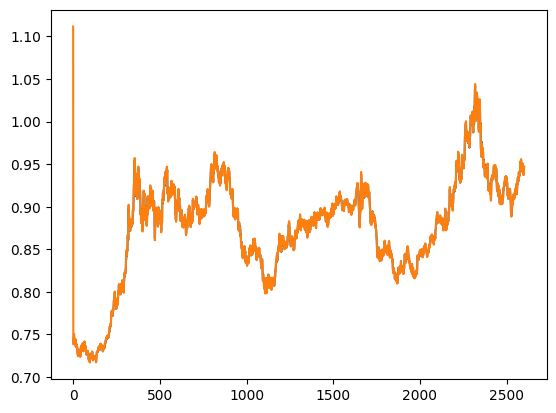

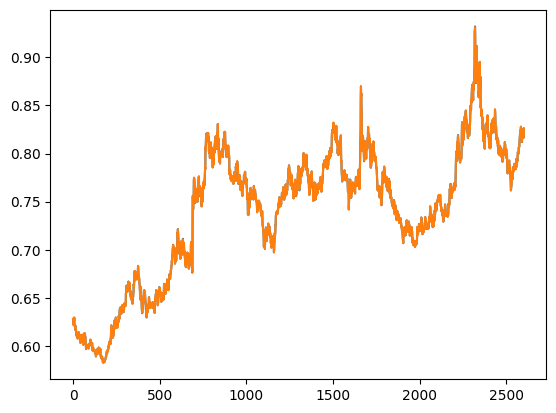

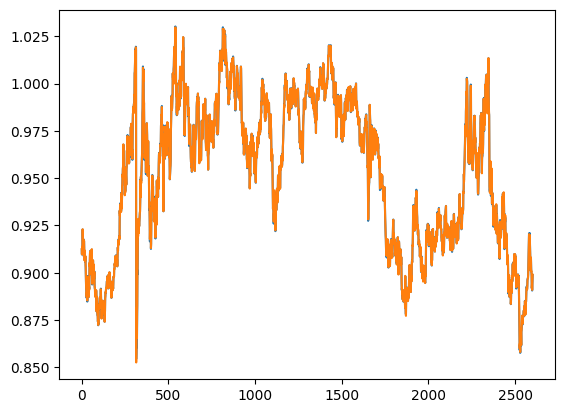

In [41]:
models=[]
for i in range(len(filepath)):
    models.append(get_best_model(df_train[i],best_parameters[i]))

## Compute Max Profit

In [42]:
ARIMA_predictions=[]
for i in range(len(filepath)):
    ARIMA_predictions.append(models[i].get_forecast(len(df_test[i])).predicted_mean)

In [43]:
ARIMA_predictions=np.array(ARIMA_predictions)
ARIMA_predictions

array([[0.94680873, 0.94720008, 0.94831501, 0.94823409, 0.9480505 ],
       [0.82381117, 0.82383511, 0.82380072, 0.82354914, 0.82338919],
       [0.89894091, 0.89923411, 0.89942069, 0.8995849 , 0.89951564]])

In [44]:
true_rate=[]
for i in range(len(filepath)):
    true_rate.append(np.array(df_test[i]).squeeze())

In [45]:
true_rate=np.array(true_rate)
true_rate

array([[0.94675, 0.94206, 0.94526, 0.94455, 0.9417 ],
       [0.82551, 0.82198, 0.8229 , 0.82087, 0.82022],
       [0.9024 , 0.90206, 0.9098 , 0.90555, 0.9061 ]])

In [46]:
def get_max_profit(rate):
    #We initially have 1000 dollars
    principal=1000
    # 5 days in total, we have 4 chances to make a profit
    for i in range(4):
        #Here, we initialize rate_increase to be 1. This is to prevent elements in rate_increase are all smaller than 1.
        rate_increase=np.array([1])
        #Here, we only need the first three predictions.
        for j in range(3):
            rate_increase=np.append(rate_increase,rate[j][i+1]/rate[j][-1])
        max_rate_increase=np.max(rate_increase)
        principal*=max_rate_increase
    return principal

In [47]:
predict_profit=get_max_profit(ARIMA_predictions)
true_profit=get_max_profit(true_rate)
print(predict_profit,true_profit)

1001.2361066551009 1009.2832827339628


In [48]:
#Compute MSE between the max profit computed via ARIMA and the actual profit 
profit_mse = (predict_profit-true_profit)**2
print("MSE between the max profit computed via ARIMA and the actual profit is:", profit_mse)

MSE between the max profit computed via ARIMA and the actual profit is: 64.75704284420665


# SARIMA

In [49]:
#seperates data set
train_size=len(df_train[0][:-5])

train=np.array(df_train[0]['rate'])[:train_size]
val=np.array(df_train[0]['rate'])[train_size:]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.83559D+00    |proj g|=  6.63358D+01

At iterate    5    f= -3.89769D+00    |proj g|=  1.08725D-01

At iterate   10    f= -3.89859D+00    |proj g|=  1.05096D+01

At iterate   15    f= -3.90958D+00    |proj g|=  3.61286D+00

At iterate   20    f= -3.91371D+00    |proj g|=  1.62780D+01

At iterate   25    f= -3.95749D+00    |proj g|=  1.90085D+00

At iterate   30    f= -3.95981D+00    |proj g|=  1.58975D+00

At iterate   35    f= -3.96052D+00    |proj g|=  3.62441D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


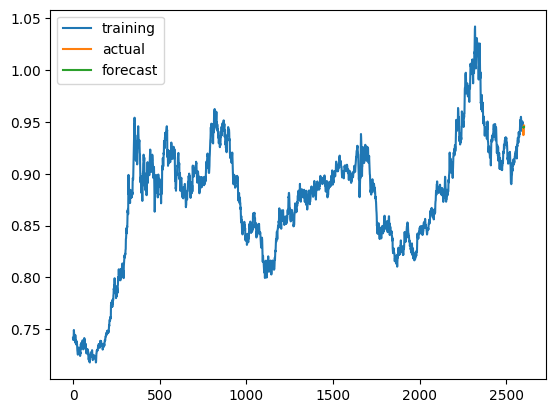

In [50]:
# train SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# initial parameters
sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1,1,1,12))
result = sarima.fit()
train_prediction = result.predict()
val_predictions = result.get_forecast(len(val)).predicted_mean

plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

## Error Calculation

In [51]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(result.predict(),train)
val_mse = mean_squared_error(val_predictions, val)

## Fine tuning

In [52]:
def get_best_model_sarima(df,best_parameter):
    #train using the whole training dataset
    train=np.array(df['rate'])

    
    #visualize the best case
    optimal_p, optimal_d, optimal_q=best_parameter
    model =  SARIMAX(train, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(p,d,q,12))
    result = model.fit()

    train_predictions = result.predict(start=1, end=train.shape[0])

    plt.plot(train,label='training')
    plt.plot(train_predictions,label='train_prediction')
    plt.show()

    return result

In [53]:
def fine_tune_sarima(df):
    #split dataset
    train_size=len(df[:-5])

    train=np.array(df['rate'])[:train_size]
    val=np.array(df['rate'])[train_size:]
    
    #fine-tuning
                    
    q_optimized = 0
    d_optimized = 0
    p_optimized = 0

    smallest_error = -1
    for q in range(1, 3):
        for d in range(1, 3):
            for p in range(1, 3):
                sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(p,d,q,12))
                sarima_model.fit()
                train_prediction = result.predict()
                val_predictions = result.get_forecast(len(val)).predicted_mean
                if (smallest_error == -1):
                    smallest_error = mean_squared_error(val_predictions, val)
                else:
                    err = mean_squared_error(val_predictions, val)
                    if (err < smallest_error):
                        smallest_error = err
                        q_optimized = q
                        d_optimized = d
                        p_optimized = p
    
    return p_optimized,d_optimized,q_optimized

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.83559D+00    |proj g|=  6.63358D+01

At iterate    5    f= -3.89769D+00    |proj g|=  1.08725D-01

At iterate   10    f= -3.89859D+00    |proj g|=  1.05096D+01

At iterate   15    f= -3.90958D+00    |proj g|=  3.61286D+00

At iterate   20    f= -3.91371D+00    |proj g|=  1.62780D+01

At iterate   25    f= -3.95749D+00    |proj g|=  1.90085D+00

At iterate   30    f= -3.95981D+00    |proj g|=  1.58975D+00

At iterate   35    f= -3.96052D+00    |proj g|=  3.62441D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     65      1     0     0   2.166D-02  -3.961D+00
  F =  -3.9605505172495041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.83062D+00    |proj g|=  6.47243D+01


 This problem is unconstrained.



At iterate    5    f= -3.88911D+00    |proj g|=  4.08075D-01

At iterate   10    f= -3.89103D+00    |proj g|=  1.50954D+01

At iterate   15    f= -3.90166D+00    |proj g|=  1.99145D-01

At iterate   20    f= -3.91579D+00    |proj g|=  9.50844D+00

At iterate   25    f= -3.91988D+00    |proj g|=  4.64202D-01

At iterate   30    f= -3.92042D+00    |proj g|=  6.41867D+00

At iterate   35    f= -3.93174D+00    |proj g|=  1.93219D+01

At iterate   40    f= -3.94225D+00    |proj g|=  1.46567D-01

At iterate   45    f= -3.94233D+00    |proj g|=  2.39122D+00


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.94325D+00    |proj g|=  3.38620D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68      1     0     0   3.386D-01  -3.943D+00
  F =  -3.9432504484263444     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.29071D+00    |proj g|=  5.60317D+01


 This problem is unconstrained.



At iterate    5    f= -3.53524D+00    |proj g|=  2.14696D-01

At iterate   10    f= -3.53703D+00    |proj g|=  1.20719D+01

At iterate   15    f= -3.58153D+00    |proj g|=  9.37719D+00

At iterate   20    f= -3.59673D+00    |proj g|=  1.78543D+01

At iterate   25    f= -3.69339D+00    |proj g|=  4.51823D+00

At iterate   30    f= -3.70758D+00    |proj g|=  1.89003D+00

At iterate   35    f= -3.70814D+00    |proj g|=  2.66739D+00

At iterate   40    f= -3.71004D+00    |proj g|=  7.27658D+00

At iterate   45    f= -3.72597D+00    |proj g|=  2.46448D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     81   

 This problem is unconstrained.



At iterate    5    f= -3.49745D+00    |proj g|=  1.97071D-01

At iterate   10    f= -3.49776D+00    |proj g|=  4.74138D+00

At iterate   15    f= -3.53093D+00    |proj g|=  4.83516D+01

At iterate   20    f= -3.57113D+00    |proj g|=  1.73352D-01

At iterate   25    f= -3.57597D+00    |proj g|=  7.69501D+00

At iterate   30    f= -3.68769D+00    |proj g|=  1.15587D+00

At iterate   35    f= -3.68858D+00    |proj g|=  1.20329D+01

At iterate   40    f= -3.72108D+00    |proj g|=  4.44006D+00

At iterate   45    f= -3.74265D+00    |proj g|=  8.89085D-01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.74330D+00    |proj g|=  1.54338D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      1     0     0   1.543D+00  -3.743D+00
  F =  -3.7433010350718088     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.84985D+00    |proj g|=  7.11468D+01


 This problem is unconstrained.



At iterate    5    f= -3.92371D+00    |proj g|=  5.54991D-02

At iterate   10    f= -3.92611D+00    |proj g|=  2.11610D+01

At iterate   15    f= -3.93345D+00    |proj g|=  2.65680D-01

At iterate   20    f= -3.93653D+00    |proj g|=  1.32052D+01

At iterate   25    f= -3.94959D+00    |proj g|=  1.28814D-01

At iterate   30    f= -3.94973D+00    |proj g|=  1.36788D+00

At iterate   35    f= -3.95293D+00    |proj g|=  9.67208D+00

At iterate   40    f= -3.95510D+00    |proj g|=  1.99665D-01

At iterate   45    f= -3.95516D+00    |proj g|=  6.88017D-01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.95617D+00    |proj g|=  2.65200D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   2.652D+00  -3.956D+00
  F =  -3.9561725282369773     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.84805D+00    |proj g|=  7.03512D+01


 This problem is unconstrained.



At iterate    5    f= -3.92020D+00    |proj g|=  5.87917D-02

At iterate   10    f= -3.92050D+00    |proj g|=  7.24238D+00

At iterate   15    f= -3.92789D+00    |proj g|=  4.91597D+00

At iterate   20    f= -3.92862D+00    |proj g|=  1.65410D+00

At iterate   25    f= -3.93715D+00    |proj g|=  2.06887D+00

At iterate   30    f= -3.93736D+00    |proj g|=  8.92737D-02

At iterate   35    f= -3.93964D+00    |proj g|=  8.89694D+00

At iterate   40    f= -3.95750D+00    |proj g|=  1.98672D+00

At iterate   45    f= -3.95809D+00    |proj g|=  1.81684D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     64   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.22277D+00    |proj g|=  3.94142D+01


 This problem is unconstrained.



At iterate    5    f= -3.30429D+00    |proj g|=  3.04036D+00

At iterate   10    f= -3.37431D+00    |proj g|=  6.96501D+01

At iterate   15    f= -3.51905D+00    |proj g|=  1.88765D-01

At iterate   20    f= -3.60104D+00    |proj g|=  4.20533D-02

At iterate   25    f= -3.60887D+00    |proj g|=  4.68480D-01

At iterate   30    f= -3.61113D+00    |proj g|=  1.08398D+00

At iterate   35    f= -3.64826D+00    |proj g|=  2.98195D+01

At iterate   40    f= -3.72467D+00    |proj g|=  3.93862D+01

At iterate   45    f= -3.82788D+00    |proj g|=  2.11390D+00


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.89510D+00    |proj g|=  8.80392D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      1     0     0   8.804D+00  -3.895D+00
  F =  -3.8950963236526484     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.35804D+00    |proj g|=  6.45006D+01


 This problem is unconstrained.



At iterate    5    f= -3.70034D+00    |proj g|=  1.59910D-01

At iterate   10    f= -3.70097D+00    |proj g|=  8.08759D+00

At iterate   15    f= -3.72190D+00    |proj g|=  1.15095D+01

At iterate   20    f= -3.72281D+00    |proj g|=  1.09645D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     20     38      1     0     0   1.096D-01  -3.723D+00
  F =  -3.7228117412700739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -3.89010D+00    |proj g|=  3.90396D-01

At iterate   10    f= -3.89168D+00    |proj g|=  1.36254D+01

At iterate   15    f= -3.90203D+00    |proj g|=  8.20182D-01

At iterate   20    f= -3.90206D+00    |proj g|=  5.57925D-02

At iterate   25    f= -3.90230D+00    |proj g|=  3.26993D+00

At iterate   30    f= -3.91930D+00    |proj g|=  8.25589D+00

At iterate   35    f= -3.92105D+00    |proj g|=  9.43543D-01

At iterate   40    f= -3.94228D+00    |proj g|=  6.66504D+00

At iterate   45    f= -3.95385D+00    |proj g|=  8.00870D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.95455D+00    |proj g|=  1.24988D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     70      1     0     0   1.250D-01  -3.955D+00
  F =  -3.9545533444181675     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.82205D+00    |proj g|=  6.25649D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1      7      1     0     0   6.256D+01  -3.822D+00
  F =  -3.8220457132438481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.28990D+00    |proj g|=  5.55608D+01

At iterate    5    f= -3.52556D+00    |proj g|=  1.46917D-01

At iterate   10    f= -3.52568D+00    |proj g|=  2.90752D+00

At iterate   15    f= -3.53951D+00    |proj g|=  3.39243D+01

At iterate   20    f= -3.57288D+00    |proj g|=  1.65994D-01

At iterate   25    f= -3.57364D+00    |proj g|=  6.33944D+00

At iterate   30    f= -3.63370D+00    |proj g|=  3.50048D+01

At iterate   35    f= -3.69638D+00    |proj g|=  8.84946D-01

At iterate   40    f= -3.69680D+00    |proj g|=  2.27776D+00

At iterate   45    f= -3.70581D+00    |proj g|=  1.72636D+00


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.70696D+00    |proj g|=  2.01598D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     74      1     0     0   2.016D+00  -3.707D+00
  F =  -3.7069572983383354     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.28456D+00    |proj g|=  5.45664D+01

At iterate    5    f= -3.50634D+00    |proj g|=  1.97082D-01

At iterate   10    f= -3.50665D+00    |proj g|=  4.75257D+00

At iterate   15    f= -3.54134D+00    |proj g|=  5.68073D+01

At iterate   20    f= -3.59640D+00    |proj g|=  1.43579D-01

At iterate   25    f= -3.60372D+00    |proj g|=  7.19517D+00

At iterate   30    f= -3.69798D+00    |proj g|=  2.36847D-01

At iterate   35    f= -3.69815D+00    |proj g|=  1.25899D+00

At iterate   40    f= -3.71804D+00    |proj g|=  2.77551D+00

At iterate   45    f= -3.74262D+00    |proj g|=  3.39058D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f= -3.91854D+00    |proj g|=  5.47646D-02

At iterate   10    f= -3.91863D+00    |proj g|=  3.74632D+00

At iterate   15    f= -3.92636D+00    |proj g|=  2.28889D+01

At iterate   20    f= -3.92955D+00    |proj g|=  3.58203D-01

At iterate   25    f= -3.92990D+00    |proj g|=  1.72852D+00

At iterate   30    f= -3.94296D+00    |proj g|=  5.09949D+00

At iterate   35    f= -3.95220D+00    |proj g|=  1.14376D+00

At iterate   40    f= -3.95221D+00    |proj g|=  5.67149D-01

At iterate   45    f= -3.95245D+00    |proj g|=  7.14732D-01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.95267D+00    |proj g|=  5.75372D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   5.754D-01  -3.953D+00
  F =  -3.9526701845987859     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.84324D+00    |proj g|=  6.97318D+01

At iterate    5    f= -3.91400D+00    |proj g|=  6.00976D-02

At iterate   10    f= -3.91407D+00    |proj g|=  3.50705D+00

At iterate   15    f= -3.91943D+00    |proj g|=  1.79878D+01

At iterate   20    f= -3.92183D+00    |proj g|=  3.15656D-01

At iterate   25    f= -3.92896D+00    |proj g|=  1.35307D+00

At iterate   30    f= -3.93131D+00    |proj g|=  2.86561D-01

At iterate   35    f= -3.93636D+00    |proj g|=  4.40984D+00

At iterate   40    f= -3.95080D+00    |proj g|=  1.03475D+00

At iterate   45    f= -3.95085D+00    |proj g|=  2.25443D-01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.95288D+00    |proj g|=  3.75813D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     73      1     0     0   3.758D+00  -3.953D+00
  F =  -3.9528827219071143     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.03311D+00    |proj g|=  7.26153D+00

At iterate    5    f= -3.30675D+00    |proj g|=  7.79956D+01

At iterate   10    f= -3.38700D+00    |proj g|=  3.65266D-01

At iterate   15    f= -3.48843D+00    |proj g|=  1.76691D+01

At iterate   20    f= -3.60645D+00    |proj g|=  1.00189D+01

At iterate   25    f= -3.62111D+00    |proj g|=  7.07539D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     43      1     0     0   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27401D+00    |proj g|=  4.93540D+01

At iterate    5    f= -3.42089D+00    |proj g|=  4.81642D-01

At iterate   10    f= -3.43172D+00    |proj g|=  2.19338D+01

At iterate   15    f= -3.60243D+00    |proj g|=  1.81745D+00

At iterate   20    f= -3.61088D+00    |proj g|=  1.06745D+00

At iterate   25    f= -3.63555D+00    |proj g|=  3.51103D+01

At iterate   30    f= -3.68168D+00    |proj g|=  1.32442D-01

At iterate   35    f= -3.69822D+00    |proj g|=  6.45243D+00

At iterate   40    f= -3.73516D+00    |proj g|=  1.37338D+01

At iterate   45    f= -3.73871D+00    |proj g|=  3.28524D-01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.74005D+00    |proj g|=  8.34923D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     66      1     0     0   8.349D-01  -3.740D+00
  F =  -3.7400544048138906     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.59852D+00    |proj g|=  5.14022D+01


 This problem is unconstrained.



At iterate    5    f= -3.65756D+00    |proj g|=  9.68797D-02

At iterate   10    f= -3.65779D+00    |proj g|=  4.23570D+00

At iterate   15    f= -3.66768D+00    |proj g|=  1.54123D+01

At iterate   20    f= -3.67370D+00    |proj g|=  2.10303D+00

At iterate   25    f= -3.72398D+00    |proj g|=  2.77525D+00

At iterate   30    f= -3.72593D+00    |proj g|=  5.06570D-01

At iterate   35    f= -3.72959D+00    |proj g|=  2.94869D-01

At iterate   40    f= -3.72976D+00    |proj g|=  1.82651D-02

At iterate   45    f= -3.73013D+00    |proj g|=  2.23224D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.73015D+00    |proj g|=  2.09217D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   2.092D-01  -3.730D+00
  F =  -3.7301511604844020     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.59432D+00    |proj g|=  5.03250D+01


 This problem is unconstrained.



At iterate    5    f= -3.65045D+00    |proj g|=  7.48220D-01

At iterate   10    f= -3.65996D+00    |proj g|=  1.80949D+01

At iterate   15    f= -3.66519D+00    |proj g|=  5.35759D-02

At iterate   20    f= -3.67037D+00    |proj g|=  1.87444D+00

At iterate   25    f= -3.68659D+00    |proj g|=  8.79753D-01

At iterate   30    f= -3.68684D+00    |proj g|=  1.70900D-01

At iterate   35    f= -3.71066D+00    |proj g|=  8.23395D+00

At iterate   40    f= -3.71628D+00    |proj g|=  3.35764D+00

At iterate   45    f= -3.71653D+00    |proj g|=  3.67499D-01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.71686D+00    |proj g|=  4.28283D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   4.283D-01  -3.717D+00
  F =  -3.7168603557639068     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07790D+00    |proj g|=  4.48228D+01

At iterate    5    f= -3.31282D+00    |proj g|=  6.15868D-01

At iterate   10    f= -3.31505D+00    |proj g|=  1.11907D+01

At iterate   15    f= -3.36289D+00    |proj g|=  2.83900D-01

At iterate   20    f= -3.37237D+00    |proj g|=  1.30466D+01

At iterate   25    f= -3.47224D+00    |proj g|=  1.24165D+01

At iterate   30    f= -3.48850D+00    |proj g|=  1.40065D+00

At iterate   35    f= -3.49044D+00    |proj g|=  1.15288D+00

At iterate   40    f= -3.49372D+00    |proj g|=  2.23489D+00

At iterate   45    f= -3.49437D+00    |proj g|=  8.22632D-01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.49466D+00    |proj g|=  2.26414D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   2.264D-01  -3.495D+00
  F =  -3.4946633964496319     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.06507D+00    |proj g|=  4.31296D+01


 This problem is unconstrained.



At iterate    5    f= -3.27338D+00    |proj g|=  1.96136D-01

At iterate   10    f= -3.27432D+00    |proj g|=  6.73710D+00

At iterate   15    f= -3.33309D+00    |proj g|=  2.99302D+01

At iterate   20    f= -3.34691D+00    |proj g|=  5.95782D-01

At iterate   25    f= -3.36105D+00    |proj g|=  1.95811D+01

At iterate   30    f= -3.44445D+00    |proj g|=  5.84744D+00

At iterate   35    f= -3.44629D+00    |proj g|=  4.43761D+00

At iterate   40    f= -3.45533D+00    |proj g|=  1.41259D+01

At iterate   45    f= -3.48913D+00    |proj g|=  2.88597D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.49222D+00    |proj g|=  1.45290D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     86      2     0     0   1.453D-01  -3.492D+00
  F =  -3.4922190518526017     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.61619D+00    |proj g|=  5.61507D+01


 This problem is unconstrained.



At iterate    5    f= -3.68966D+00    |proj g|=  2.43936D-01
  ys=-1.744E-11  -gs= 2.552E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6     62      2     1     0   2.439D-01  -3.690D+00
  F =  -3.6896573080630235     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.61666D+00    |proj g|=  5.61262D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      4     10      1     0     0   8.290D-02  -3.690D+00
  F =  -3.6899069597566241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.99858D+00    |proj g|=  3.14820D+01


 This problem is unconstrained.



At iterate    5    f= -3.08366D+00    |proj g|=  7.69731D+00

At iterate   10    f= -3.25335D+00    |proj g|=  2.80950D+01

At iterate   15    f= -3.28087D+00    |proj g|=  1.90515D-01

At iterate   20    f= -3.34454D+00    |proj g|=  7.08208D+00

At iterate   25    f= -3.36519D+00    |proj g|=  1.01738D-01

At iterate   30    f= -3.36528D+00    |proj g|=  4.05986D-01

At iterate   35    f= -3.36990D+00    |proj g|=  3.98590D+00

At iterate   40    f= -3.37812D+00    |proj g|=  9.85146D+00

At iterate   45    f= -3.38141D+00    |proj g|=  1.17527D-01

At iterate   50    f= -3.38144D+00    |proj g|=  2.11090D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13192D+00    |proj g|=  5.08552D+01


 This problem is unconstrained.



At iterate    5    f= -3.46072D+00    |proj g|=  3.70746D-01

At iterate   10    f= -3.46276D+00    |proj g|=  1.21440D+01

At iterate   15    f= -3.47986D+00    |proj g|=  9.41671D-01

At iterate   20    f= -3.48156D+00    |proj g|=  7.02786D-01

At iterate   25    f= -3.48841D+00    |proj g|=  2.36731D+00

At iterate   30    f= -3.49537D+00    |proj g|=  1.15809D+00

At iterate   35    f= -3.55755D+00    |proj g|=  4.72003D+00

At iterate   40    f= -3.57170D+00    |proj g|=  4.29695D-01

At iterate   45    f= -3.57786D+00    |proj g|=  3.00773D-01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.57820D+00    |proj g|=  9.42592D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     73      1     0     0   9.426D+00  -3.578D+00
  F =  -3.5782040418493390     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.75931D+00    |proj g|=  7.49912D+00


 This problem is unconstrained.



At iterate    5    f= -2.76315D+00    |proj g|=  4.55231D-01

At iterate   10    f= -2.76664D+00    |proj g|=  6.70096D+00

At iterate   15    f= -2.77351D+00    |proj g|=  7.67548D-01

At iterate   20    f= -2.77517D+00    |proj g|=  2.35084D+00

At iterate   25    f= -2.77571D+00    |proj g|=  1.87112D-01

At iterate   30    f= -2.77671D+00    |proj g|=  1.51582D+00

At iterate   35    f= -2.77735D+00    |proj g|=  8.23299D-02

At iterate   40    f= -2.77917D+00    |proj g|=  2.74955D+00

At iterate   45    f= -2.78454D+00    |proj g|=  3.82630D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.78461D+00    |proj g|=  1.97681D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59      1     0     0   1.977D-01  -2.785D+00
  F =  -2.7846144216047621     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


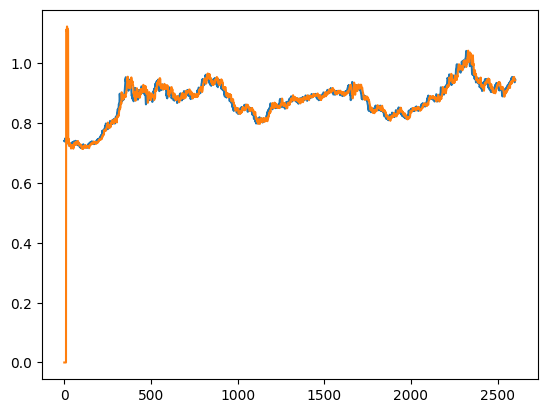

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.71331D+00    |proj g|=  7.30090D+00


 This problem is unconstrained.



At iterate    5    f= -2.72568D+00    |proj g|=  9.13004D-02

At iterate   10    f= -2.72921D+00    |proj g|=  1.40870D-01

At iterate   15    f= -2.73417D+00    |proj g|=  1.03753D+00

At iterate   20    f= -2.74142D+00    |proj g|=  4.53277D-02

At iterate   25    f= -2.74509D+00    |proj g|=  2.75329D-02

At iterate   30    f= -2.74659D+00    |proj g|=  1.91278D-01

At iterate   35    f= -2.74791D+00    |proj g|=  1.02501D+00

At iterate   40    f= -2.74889D+00    |proj g|=  6.31821D-02

At iterate   45    f= -2.75007D+00    |proj g|=  3.34404D-01

At iterate   50    f= -2.75104D+00    |proj g|=  2.68799D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


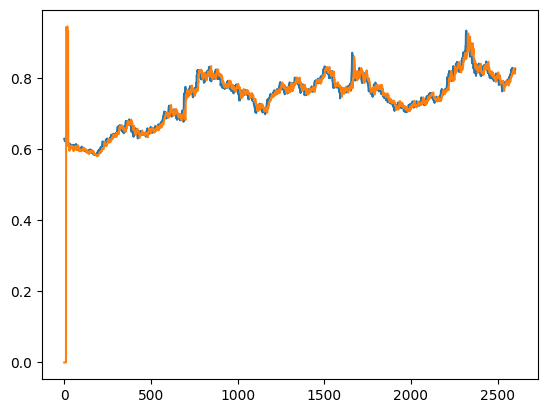

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.49860D+00    |proj g|=  1.70461D+00

At iterate    5    f= -2.49966D+00    |proj g|=  2.12587D+00

At iterate   10    f= -2.52957D+00    |proj g|=  7.19357D+00

At iterate   15    f= -2.57185D+00    |proj g|=  3.02899D+00

At iterate   20    f= -2.59111D+00    |proj g|=  2.59649D-01

At iterate   25    f= -2.59122D+00    |proj g|=  5.34884D-02

At iterate   30    f= -2.59202D+00    |proj g|=  8.38933D-02

At iterate   35    f= -2.59215D+00    |proj g|=  5.64332D-01

At iterate   40    f= -2.59223D+00    |proj g|=  1.01041D-02

At iterate   45    f= -2.59223D+00    |proj g|=  3.37769D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.59226D+00    |proj g|=  7.38821D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   7.388D-02  -2.592D+00
  F =  -2.5922590545281805     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


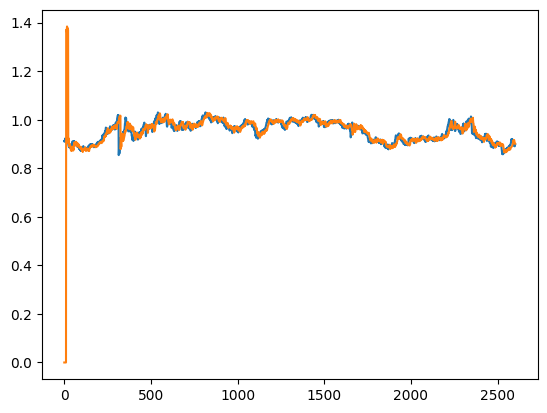

In [54]:
#find best hyper parameters for each dataset
best_parameters_sarima=[]
for i in range(3):
    best_parameters_sarima.append(fine_tune_sarima(df_train[i]))

models_sarima=[]
for i in range(3):
    models_sarima.append(get_best_model_sarima(df_train[i],best_parameters_sarima[i]))


In [55]:
SARIMA_predictions=[]
for i in range(3):
    SARIMA_predictions.append(models_sarima[i].get_forecast(len(df_test[i])).predicted_mean)

# Model Assembling

In [56]:
pred_prophet=np.array(pred_prophet)
pred_prophet

array([[0.95998819, 0.96052382, 0.96090362, 0.96164356, 0.96216071],
       [0.84676312, 0.84711607, 0.84692246, 0.84695669, 0.84741094],
       [0.91829924, 0.9186235 , 0.91919013, 0.9190048 , 0.91970321]])

In [57]:
ARIMA_predictions

array([[0.94680873, 0.94720008, 0.94831501, 0.94823409, 0.9480505 ],
       [0.82381117, 0.82383511, 0.82380072, 0.82354914, 0.82338919],
       [0.89894091, 0.89923411, 0.89942069, 0.8995849 , 0.89951564]])

In [58]:
SARIMA_predictions=np.array(SARIMA_predictions)
SARIMA_predictions

array([[0.94304615, 0.95117565, 0.95304133, 0.94959952, 0.94809493],
       [0.81224754, 0.82130186, 0.8240218 , 0.81862923, 0.81992232],
       [0.9012096 , 0.90770479, 0.90526367, 0.90254682, 0.90170761]])

In [62]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

weights = []

for i in range(len(filepath)):
    x1=pred_prophet[i]
    x2=ARIMA_predictions[i]
    x3=SARIMA_predictions[i]

    X_train = np.column_stack((x1, x2, x3))
    y_train = true_rate[i]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    weights.append(model.coef_)

In [63]:
print(weights)

[array([-3.97912225,  5.47805435, -0.59235615]), array([-1.53345852,  6.32883082, -0.22239298]), array([3.18462072, 2.23060773, 0.06789237])]
